In [334]:
!pip install shap==0.42.0

In [335]:
import shap
shap.__version__

'0.42.0'

In [336]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Conv2D, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
from scipy.io import loadmat
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [337]:

X=loadmat('../input/salinas/salinas_corrected.mat')['salinas_corrected']
y=loadmat('../input/salinas/salinas_gt.mat')['salinas_gt']
    

In [338]:
dataset='PU'
test_ratio=0.3
pixelsize=5

In [339]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [340]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [341]:
X.shape

(512, 217, 204)

In [342]:
#def applyPCA(X, numComponents=80):
    #newX = np.reshape(X, (-1, X.shape[2]))
    #pca = PCA(n_components=numComponents, whiten=True)
    #newX = pca.fit_transform(newX)
    #newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    #return newX, pca

In [343]:
X.shape 

(512, 217, 204)

In [344]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [345]:
X.shape, y.shape

((512, 217, 204), (512, 217))

In [346]:
K=X.shape[2]
K

204

In [347]:
X, y = createImageCubes(X, y, windowSize=5)

X.shape, y.shape

((54129, 5, 5, 204), (54129,))

In [348]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((37890, 5, 5, 204), (16239, 5, 5, 204), (37890,), (16239,))

In [349]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((25261, 5, 5, 204), (12629, 5, 5, 204), (25261,), (12629,))

In [350]:
print(Xtrain.shape)

(25261, 5, 5, 204)


In [351]:
Xtrain = Xtrain.reshape(-1, 5, 5, 204, 1) #5 5 olanlar pixelSize
Xtrain.shape

(25261, 5, 5, 204, 1)

In [352]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(25261, 16)

In [353]:
Xvalid = Xvalid.reshape(-1, 5, 5, 204, 1) 
Xvalid.shape

(12629, 5, 5, 204, 1)

In [354]:
yvalid=np_utils.to_categorical(yvalid)
yvalid.shape

(12629, 16)

In [363]:
# Input layer
input_layer = Input((5, 5, 204, 1))

# 2D Convolutional Layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same')(conv_layer1)
conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same')(conv_layer2)
conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same')(conv_layer3)

# Reshape layer to flatten
conv2d_shape = conv_layer4.shape
reshaped_layer = Reshape((conv2d_shape[1], conv2d_shape[2], conv2d_shape[3]*conv2d_shape[4]))(conv_layer4)

# Additional 2D Convolutional Layer
conv_layer5 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(reshaped_layer)

# Flatten layer
flatten_layer = Flatten()(conv_layer5)

# Dense Layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)

# Output Layer
output_layer = Dense(units=16, activation='softmax')(dense_layer2)

In [364]:
model=Model(inputs=input_layer,outputs=output_layer)


In [365]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 5, 5, 204, 1)]    0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 5, 204, 8)      80        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 5, 5, 204, 16)     1168      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 5, 5, 204, 32)     4640      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 5, 5, 204, 64)     18496     
_________________________________________________________________
reshape_11 (Reshape)         (None, 5, 5, 13056)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 3, 3, 128)         150

In [366]:
adam=Adam(learning_rate=0.001,decay=1e-06)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [367]:
filepath = "furkan.hdf5"
metric='acc'
#checkpoint=ModelCheckpoint(filepath=filepath,monitor=metric,verbose=1,save_best_only=True,mode='max')
#callback_list=[checkpoint]

In [370]:
history=model.fit(x=Xtrain,y=ytrain,validation_data=(Xvalid,yvalid),epochs=3)

Epoch 1/3
790/790 [==============================] - 54s 68ms/step - loss: 0.4090 - accuracy: 0.8348 - val_loss: 0.2764 - val_accuracy: 0.8948
Epoch 2/3
790/790 [==============================] - 53s 67ms/step - loss: 0.3559 - accuracy: 0.8566 - val_loss: 0.2590 - val_accuracy: 0.9007
Epoch 3/3
790/790 [==============================] - 53s 67ms/step - loss: 0.3385 - accuracy: 0.8627 - val_loss: 0.2176 - val_accuracy: 0.9138


In [371]:
model.save("furkan.hdf5")

In [372]:
import shap
shap.__version__

'0.42.0'

In [373]:
Xtest.shape

(16239, 5, 5, 204)

In [374]:
Xtrain.shape

(25261, 5, 5, 204, 1)

In [375]:
ytest.shape

(16239,)

In [376]:
ytrain.shape

(25261, 16)

In [377]:
Xtrain.shape

(25261, 5, 5, 204, 1)

In [378]:
shap_input = Xtrain[:50]

In [379]:
import shap
import warnings

explainer = shap.DeepExplainer(model, shap_input)

# Test seti üzerinde SHAP değerlerini hesaplama
shap_values = explainer.shap_values(shap_input)

# Özelliklerin SHAP değerlerini görselleştirme

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/opt/conda/lib/python3.7/site-packages/keras/backend.py:401: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



In [380]:
shap_values[0].shape

(50, 5, 5, 204, 1)

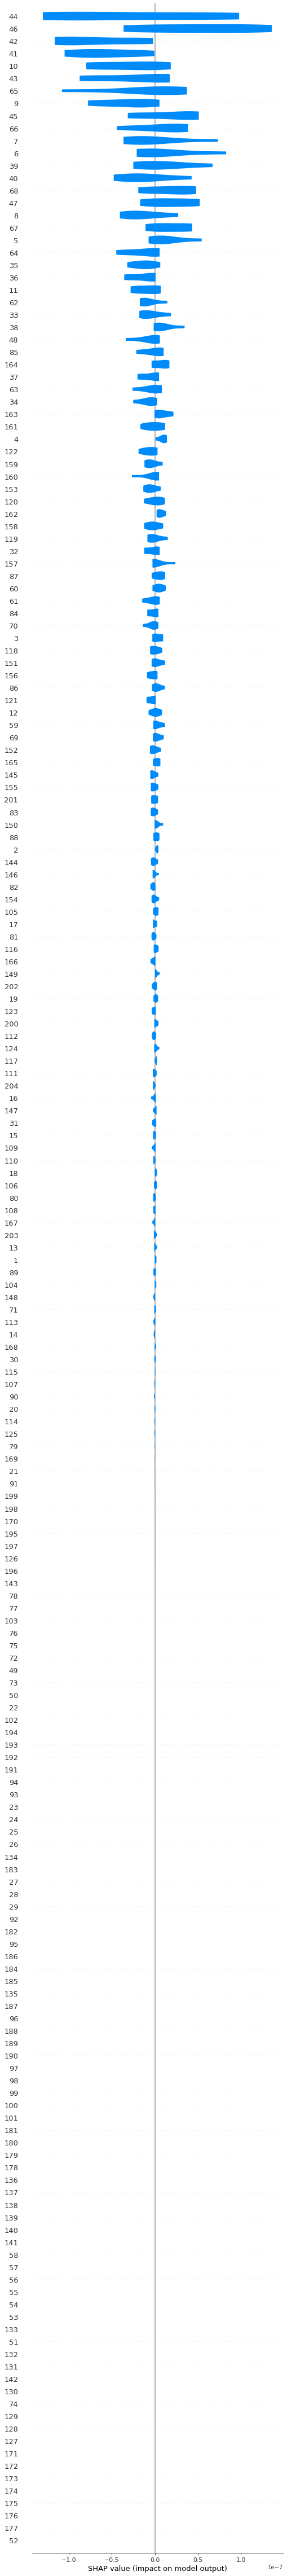

In [383]:
#############################[X]
shap_values2 = shap_values[0][2][0][:205].reshape((5, 204))
shap_values2.shape
shap.plots.violin(shap_values2, max_display=204, feature_names = [i for i in range(1,205)], show=False)
plt.savefig("07salinasTest.jpeg")


In [382]:
shap_values[0].shape

(50, 5, 5, 204, 1)

In [ ]:
Xtrain[:20].shape

In [ ]:
shap.summary_plot(shap_values[0], Xtrain[:20], plot_type='dot')

In [ ]:
explainer.shap_values(Xtrain)

In [ ]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()



In [ ]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [ ]:
model.load_weights=("best-model1.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [ ]:
Xtest=Xtest.reshape(-1,pixelsize,pixelsize,15,1)
Xtest.shape

In [ ]:
ytest=np_utils.to_categorical(ytest)
ytest.shape

In [ ]:
Y_pred_test=model.predict(Xtest)
Y_pred_test=np.argmax(Y_pred_test,axis=1)
classification= classification_report(np.argmax(ytest,axis=1),Y_pred_test)
print(classification)

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter= confusion_matrix[0]
    list_diag= np.diag(confusion_matrix)
    list_raw_sum= np.sum(confusion_matrix,axis=1)
    each_acc=np.nan_to_num(truediv(list_diag,list_raw_sum))
    average_acc=np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
import time 
def reports(X_test,y_test,name):
    start=time.time()
    Y_pred=model.predict(X_test)
    y_pred=np.argmax(Y_pred,axis=1)
    end=time.time()
    print(end-start)
    target_names=['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Self-Blocking Bricks','Shadows']
    classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
    oa=accuracy_score(np.argmax(y_test,axis=1),y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
import os 
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
X=loadmat('../input/pavia-university-hsi/PaviaU.mat')['paviaU']
y=loadmat('../input/pavia-university-hsi/PaviaU_gt.mat')['paviaU_gt']

In [ ]:
height=y.shape[0]
weidth=y.shape[1]
PATCH_SIZE=25
numComponents=15

In [ ]:
X,pca=applyPCA(X,numComponents=numComponents)


In [ ]:
X=padWithZeros(X,PATCH_SIZE//2)


In [ ]:
outputs=np.zeros((height,weidth))
for i in range (height):
    for j in range (weidth):
        target=int(y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))


In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
